In [10]:
import visualbench as vb
from torchzero.utils.torch_tools import swap_tensors_no_use_count_check
import tqdm
from myai.video import OpenCVRenderer
import cv2
import matplotlib.pyplot as plt
import numpy as np
from abc import ABC, abstractmethod
import torch
from typing import Any, Literal
from collections.abc import Sequence, Callable


class Projector(ABC):
    def update(self, x: torch.Tensor, f: torch.Tensor, vis: "Visualizer"):
        """read the name of the method"""

    @abstractmethod
    def project(self, X: torch.Tensor, k: int,  vis: "Visualizer") -> torch.Tensor:
        """X and f are a BATCH"""

    @abstractmethod
    def unproject(self, X_proj: torch.Tensor, vis: "Visualizer") -> torch.Tensor:
        """X_proj and f are a BATCH"""




def gram_schmidt(y, x):
    """make y orthogonal to x"""
    return y - (x * y) / ((x * x).clip(min=torch.finfo(y.dtype).eps))


_Point = Literal["first", "best", "current", "best so far"] | int
class ThreePoint(Projector):
    """v1 = p1-p2, v2 = p2-p3, v2 is modified to be orthogonal to v1"""

    def __init__(
        self,
        p1: _Point = 'best',
        p2: _Point = 'first',
        p3: _Point = 'current',
        point_beta: float = 0,
        vec_beta: float = 0,
        basis_beta: float = 0,
        around_best: bool = False,
    ):
        self.p1_type: _Point = p1
        self.p2_type: _Point = p2
        self.p3_type: _Point = p3

        self.p1 = None
        self.p2 = None
        self.p3 = None

        self.v1 = None
        self.v2 = None

        self.point_beta = point_beta
        self.vec_beta = vec_beta
        self.basis_beta = basis_beta
        self.around_best = around_best

        self.basis = None
        """(n, 2)"""

    def _get_point(
        self, vis: "Visualizer", p: _Point, x: torch.Tensor, step: int
    ) -> torch.Tensor:
        if p == "first":
            return vis.X[0]
        if p == "best":
            return vis.x_min
        if p == "current":
            return x
        if p == "best so far":
            return vis.X[np.argmin(vis.f[:step])]
        if step - p >= 0:
            return vis.X[step - p]
        return vis.X[-p]

    def update(self, x, f, vis):
        eps = torch.finfo(x.dtype).eps

        # get points
        p1, p2, p3 = [
            self._get_point(vis, p, x, vis.step)
            for p in (self.p1_type, self.p2_type, self.p3_type)
        ]

        # lerp points
        if self.point_beta != 0:
            if self.p1 is None: self.p1 = p1
            else: self.p1.lerp_(p1, 1-self.point_beta)
            if self.p2 is None: self.p2 = p2
            else: self.p2.lerp_(p2, 1-self.point_beta)
            if self.p3 is None: self.p3 = p3
            else: self.p3.lerp_(p3, 1-self.point_beta)
            p1,p2,p3 = self.p1, self.p2, self.p3

        # basis vectors
        v1 = p1 - p2
        v2 = p2 - p3

        # lerp vectors before normalizing and orthogonalizing
        if self.vec_beta != 0:
            if self.v1 is None: self.v1 = v1
            else: self.v1.lerp_(v1, 1-self.point_beta)
            if self.v2 is None: self.v2 = v2
            else: self.v2.lerp_(v2, 1-self.point_beta)
            v1,v2 = self.v1, v2

        # orthogonalize
        v1 = v1 / torch.linalg.vector_norm(v1).clip(min=eps)
        v2 = v2 / torch.linalg.vector_norm(v2).clip(min=eps)
        v2 = gram_schmidt(v2, v1)

        # stack
        basis = torch.stack([v1, v2], -1)
        if self.basis is None or self.basis_beta == 0:
            self.basis = basis
        else:
            self.basis.lerp_(basis, 1-self.basis_beta)

    def project(self, X, k, vis):
        assert k == 2
        assert self.basis is not None
        if self.around_best: X = X - vis.x_min
        return X @ self.basis

    def unproject(self, X_proj, vis):
        assert self.basis is not None
        X = X_proj @ self.basis.T
        if self.around_best: X = X + vis.x_min
        return X


class Visualizer:
    def __init__(
        self,
        objective: Callable[[torch.Tensor], torch.Tensor],
        points: torch.Tensor | Sequence[torch.Tensor],
        values: torch.Tensor | Sequence[torch.Tensor],
        projector: Projector,
        grid_size: int = 20,
        extent: int = 5, # number of points to be visible before and after current point
        padding: float = 1.1, # multiplies size of visible area
        center_beta: float = 0,
        size_beta: float = 0,
        resolution: int = 256,
        cmap: Any = 'coolwarm',
        device = 'cuda',
    ):
        self.objective = objective
        self.X = torch.stack([p.detach().cpu() for p in points])
        self.f = torch.stack([v.detach().cpu() for v in values])
        self.eps = torch.tensor(torch.finfo(self.X.dtype).eps).to(self.X)

        idx = np.argmin(self.f)
        self.f_min = self.f[idx]
        self.x_min = self.X[idx]
        self.step = 0

        self.projector = projector
        self.extent = extent
        self.center_beta = center_beta
        self.size_beta = size_beta
        self.grid_size = grid_size
        self.padding = padding
        self.resolution = resolution
        self.cmap = cmap
        self.device = device

        self.center = None
        self.size = None

    @torch.no_grad
    def next_frame(self) -> np.ndarray:
        x = self.X[self.step]
        f = self.f[self.step]
        self.projector.update(x, f, self)

        # get size to include nearby points
        start = max(0, self.step - self.extent)
        end = min(len(self.X), self.step + self.extent)

        visible_X = self.X[start:end]
        if visible_X.numel() == 0:
            visible_X = self.X[self.step].unsqueeze(0)

        visible_X_proj = self.projector.project(visible_X, 2, self)
        min_x, max_x = visible_X_proj[:, 0].amin(), visible_X_proj[:, 0].amax()
        min_y, max_y = visible_X_proj[:, 1].amin(), visible_X_proj[:, 1].amax()

        # this is done to smooth center and size separately
        center_x = min_x + (max_x-min_x).clip(min=self.eps)/2
        center_y = min_y + (max_y-min_y).clip(min=self.eps)/2
        center = torch.stack([center_x, center_y])
        if self.center is None: self.center = center
        else: self.center.lerp_(center, 1-self.center_beta)

        size: torch.Tensor = max(max_x-min_x, max_y-min_y, self.eps) # pyright: ignore[reportArgumentType,reportAssignmentType]
        if self.size is None: self.size = size
        else: self.size.lerp_(size, 1-self.size_beta)

        # make a grid and evaluate the function on it
        half_size = size / 2
        x_range = torch.linspace(self.center[0]-half_size, self.center[0]+half_size, self.grid_size)
        y_range = torch.linspace(self.center[1]-half_size, self.center[1]+half_size, self.grid_size)
        grid_x, grid_y = torch.meshgrid(x_range, y_range, indexing='xy')

        grid = torch.stack([grid_x.ravel(), grid_y.ravel()]).T # (grid_size^2, 2)
        grid_unproj = self.projector.unproject(grid, self).to(self.device)
        Z = self.objective(grid_unproj).view(self.grid_size, self.grid_size)

        z_min, z_max = Z.min(), Z.max()
        if torch.isclose(z_min, z_max): Z = np.full(Z.shape, 0.5)
        else: Z = ((Z - z_min) / (z_max - z_min)).detach().cpu().numpy()
        cmap = plt.get_cmap(self.cmap)
        Z_img = (cmap(Z)[:, :, :3] * 255).astype(np.uint8)

        # project entire trajectory
        X_proj = self.projector.project(self.X, 2, self)

        # make a frame
        frame = cv2.resize(Z_img, (self.resolution, self.resolution), interpolation=cv2.INTER_LINEAR)
        view_size = self.size * self.padding
        top_left = self.center - view_size / 2

        def world_to_pixel(world_coords: torch.Tensor) -> np.ndarray:
            scaled_coords = (world_coords - top_left) / view_size.clip(min=self.eps)
            return (scaled_coords * self.resolution).cpu().numpy().clip(0, 255).astype(np.int32)

        path_pixels = world_to_pixel(X_proj[:self.step + 1])
        if len(path_pixels) > 1:
            cv2.polylines(frame, [path_pixels], isClosed=False, color=(255, 255, 255), thickness=2, lineType=cv2.LINE_AA)
            for point in path_pixels:
                cv2.drawMarker(frame, tuple(point), color=(170, 170, 170), markerType=cv2.MARKER_CROSS, markerSize=4, thickness=1)

        # best point
        best_idx_so_far = torch.argmin(self.f[:self.step + 1])
        best_point_proj = X_proj[best_idx_so_far].unsqueeze(0)
        best_pixel = world_to_pixel(best_point_proj)[0]
        cv2.drawMarker(frame, tuple(best_pixel), color=(0, 255, 0), markerSize=10, thickness=2, line_type=cv2.LINE_AA)

        # # current point
        current_pixel = path_pixels[-1]
        cv2.circle(frame, tuple(current_pixel), 5, (0, 0, 255), thickness=-1, lineType=cv2.LINE_AA)

        self.step += 1
        return frame

    def render(self, file: str, fps: int = 30):
        with OpenCVRenderer(file, fps) as r:
            for _ in tqdm.tqdm(list(range(len(self.X)))):
                r.add_frame(self.next_frame())



def for_loop(objective):
    def batched_objective(x):
        if x.ndim == 1: return objective(x)
        assert x.ndim == 2
        return torch.stack([objective(xi) for xi in x])
    return batched_objective

def bench_objective(bench):
    @torch.no_grad
    def objective(x: torch.Tensor):
        torch.nn.utils.vector_to_parameters(x, bench.parameters())
        return bench.get_loss()
    return objective


finished in 6.9s., reached loss = 0.104                                      


100%|██████████| 250/250 [12:51<00:00,  3.08s/it]


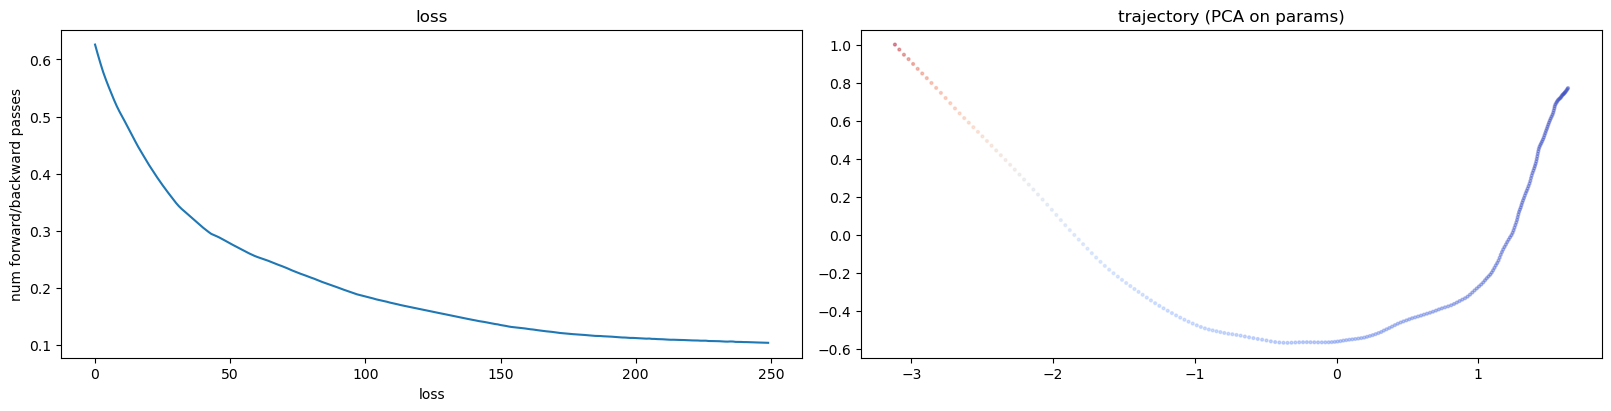

In [25]:
bench = vb.BoxPacking().cuda().set_make_images().set_log_params()
bench.run(torch.optim.Adam(bench.parameters(), 0.01), 500)

bench.plot_summary()

objective = for_loop(bench_objective(bench))
trajectory = bench.logger.tensor('params')
values = bench.logger.tensor('train loss')

v = Visualizer(objective, trajectory, values, ThreePoint(around_best=True), center_beta=0.5, size_beta=0.5, padding=2, extent=10)
v.render('vidoe around_best')